In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


# Grey-Scott 1D

---

Solution of the Gray-Scott model in 1 dimension, following the article by Giampaolo et al. (2022).

The model can be described by the following formulas:

$$
f1 = \frac{∂u}{∂t} + uv^{2} − F(1 − u) − \frac{∂^{2}u}{∂x^{2}}
$$
$$
f2 = \frac{∂v}{∂t} − uv^{2} + (F + K)v − \frac{∂^{2}v}{∂x^{2}}
$$


Based on the problem proposed by Shao et al. (2021). If $4(F + K)² < F$, then $z = x - \beta t$. 
We can rewrite the equations as

$$
0 = β\frac{du}{dz} + uv^{2} − F (1 − u) − \frac{d^{2}u}{dz^{2}}
$$
$$
0 = β\frac{dv}{dz} - uv^{2} + (F + K)v − \frac{d^{2}v}{dz^{2}}
$$

Where:

$$
β = \frac{\sqrt{2}}{4}(1 - 3\sqrt{η}) \qquad η = 1 − 4F
$$

This being the case, the boundary conditions are:

$$
(u, v)(−10) = (1, 0) \qquad (u, v)(10) = (\frac{2 − \sqrt{2}}{4}, \frac{2 + \sqrt{2}}{4})
$$

Having the following exact solution:

$$
u(z) = \frac{3 - \sqrt{η}}{4} - \frac{\sqrt{2ξ}}{4} \tanh(\frac{\sqrt ξ}{4}z)$$

$$
u(z) = \frac{1 + \sqrt{η}}{4} + \frac{\sqrt{2ξ}}{4} \tanh(\frac{\sqrt ξ}{4}z)
$$

Where:

$$
ξ = 1 + √η − 2F
$$

In [2]:
# Parameters
F = 1 / 8
K = 0

N = 1 - 4 * F
beta = (np.sqrt(2) / 4) * (1 - 3 * np.sqrt(N))
E = 1 + np.sqrt(N) - 2 * F

z0, zf = -10, 10

In [3]:
def known_solution_1st_case(z):
    return np.hstack((
        (3 - np.sqrt(N)) / 4 - (np.sqrt(2 * E) / 4) * np.tanh(np.sqrt(E) * z / 4),
        (1 + np.sqrt(N)) / 4 + (np.sqrt(2 * E) / 4) * np.tanh(np.sqrt(E) * z / 4)        
    ))


In [4]:

def grey_scott_1D_1st_case(x, y):
    
    u, v = y[:, 0:1], y[:, 1:2] # Extract u and v from the output

    du_z = dde.grad.jacobian(y, x, i=0)  # ∂u/∂z
    dv_z = dde.grad.jacobian(y, x, i=1)  # ∂v/∂z

    du_zz = dde.grad.hessian(y, x, component=0, i=0, j=0)  # ∂²u/∂z²
    dv_zz = dde.grad.hessian(y, x, component=1, i=0, j=0)  # ∂²v/∂z²

    return [
        beta * du_z + u * v**2 - F * (1 - u) - du_zz,
        beta * dv_z - u * v**2 + (F + K) * v - dv_zz,
    ]


geom = dde.geometry.geometry_1d.Interval(z0, zf)

bcu1 = dde.icbc.DirichletBC(geom, lambda z: 1, lambda z, _: dde.utils.isclose(z[0], -10), component=0)
bcv1 = dde.icbc.DirichletBC(geom, lambda z: 0, lambda z, _: dde.utils.isclose(z[0], -10), component=1)

bcu2 = dde.icbc.DirichletBC(geom, lambda z: (2 - np.sqrt(2)) / 4, lambda z, _: dde.utils.isclose(z[0], 10), component=0)
bcv2 = dde.icbc.DirichletBC(geom, lambda z: (2 + np.sqrt(2)) / 4, lambda z, _: dde.utils.isclose(z[0], 10), component=1)

data = dde.data.PDE(
    geom, 
    grey_scott_1D_1st_case,
    [bcu1, bcv1, bcu2, bcv2],
    solution=known_solution_1st_case,
    num_domain=600,
    num_boundary=150
)

layer_size = [1] + [20] * 4 + [2]
activation = "sigmoid"
initializer = "Glorot normal"
optimizer = "adam"
learning_rate = 0.001
loss_weights = [0.001, 0.001, 2, 2, 2, 2]

net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

model.compile(optimizer, lr=learning_rate, loss_weights=loss_weights)


Compiling model...
'compile' took 3.093042 s



Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.50e-05, 3.15e-07, 4.26e+00, 2.37e-02, 7.30e-01, 1.15e+00]    [3.50e-05, 3.15e-07, 4.26e+00, 2.37e-02, 7.30e-01, 1.15e+00]    []  
1000      [2.23e-06, 2.20e-06, 2.22e-11, 1.77e-11, 6.64e-11, 7.06e-11]    [2.23e-06, 2.20e-06, 2.22e-11, 1.77e-11, 6.64e-11, 7.06e-11]    []  
2000      [2.22e-06, 2.19e-06, 2.22e-11, 1.77e-11, 6.64e-11, 7.06e-11]    [2.22e-06, 2.19e-06, 2.22e-11, 1.77e-11, 6.64e-11, 7.06e-11]    []  
3000      [2.21e-06, 2.18e-06, 2.21e-11, 1.78e-11, 6.64e-11, 7.05e-11]    [2.21e-06, 2.18e-06, 2.21e-11, 1.78e-11, 6.64e-11, 7.05e-11]    []  
4000      [2.20e-06, 2.17e-06, 2.21e-11, 1.80e-11, 6.63e-11, 7.05e-11]    [2.20e-06, 2.17e-06, 2.21e-11, 1.80e-11, 6.63e-11, 7.05e-11]    []  
5000      [2.18e-06, 2.14e-06, 2.21e-11, 1.83e-11, 6.61e-11, 7.07e-11]    [2.18e-06, 2.14e-06, 2.21e-11, 1.83e-11, 6

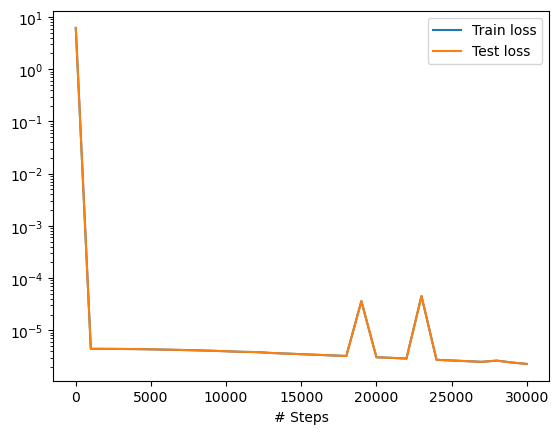

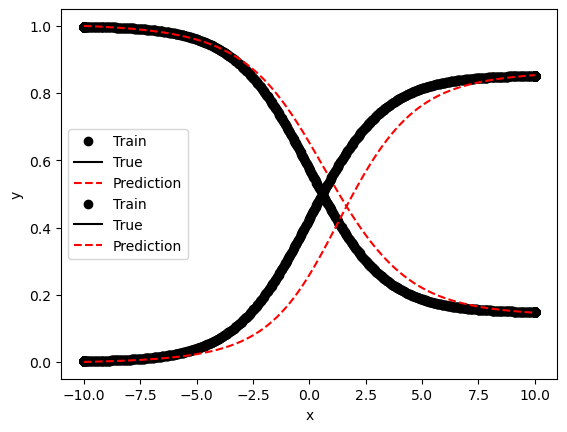

In [5]:
losshistory, train_state = model.train(iterations=25000,  model_save_path="../models/grey-scott")

dde.saveplot(losshistory, train_state, issave=False, isplot=True)


In [10]:

model.restore("../models/grey-scott-30000.pt")

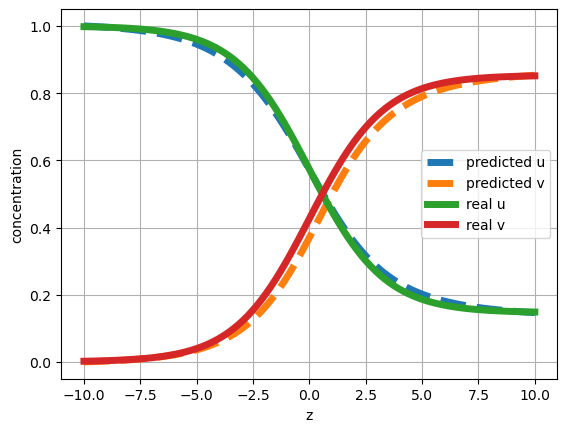

In [12]:
nop = 100

z = np.linspace(z0, zf, nop)

y_pred = model.predict(z.reshape(-1, 1))
u_pred, v_pred = y_pred[:, 0], y_pred[:, 1]

# aumentar expressura e colocar solução analítica
plt.plot(z, u_pred, "--", label="predicted u", linewidth=5)
plt.plot(z, v_pred, "--", label="predicted v", linewidth=5)

real_uv = known_solution_1st_case(z)
u_real, v_real = real_uv[:nop], real_uv[nop:]

plt.plot(z, u_real, label="real u", linewidth=5)
plt.plot(z, v_real, label="real v", linewidth=5)

plt.xlabel("z")
plt.ylabel("concentration")
plt.legend()
plt.grid()
plt.savefig("../figures/grey_scott_1d.pdf")
plt.show()

## Bibliography

Giampaolo F, De Rosa M, Qi P, Stefanno I, Cuomo S. Physics-informed neural networks approach for 1D and 2D Gray-Scott systems, Advanced Modeling and Simulation in Engineering and Science (2022) 9:52022.

Shao Y, Lin JC-W, Srivastava G, Guo D, Zhang H, Yi H, Jolfaei A. Multi-objective neural evolutionary algorithm for
combinatorial optimization problems. IEEE Transactions on Neural Networks and Learning Systems, 2021.

Manaa SA, Rasheed J. Successive and ﬁnite diﬀerence method for gray scott model. Sci J Univer Zakho. 2013;1(2):862–
73.